In [1]:
import os
import glob
import pandas as pd
from bs4 import BeautifulSoup
import gzip

In [ ]:
# Gets the maximum sequencing length from a fastq file
def max_seq_length_from_fastq(file_path, num_reads=10):
    max_len = 0
    read_count = 0

    with gzip.open(file_path, "rt") as f:  # "rt" = read text mode
        while read_count < num_reads:
            header = f.readline()
            if not header:
                break  # End of file

            sequence = f.readline().strip()
            f.readline()  # Skip '+'
            f.readline()  # Skip quality line

            max_len = max(max_len, len(sequence))
            read_count += 1

    return max_len


# Parses Demultiplax_STATS.htm (XML) file from HiSeq 2500 output
def total_count_xml(file_path):

    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "xml")  # Use XML parser for this structured file

    # Collect all entries
    data = []

    for project in soup.find_all("Project"):
        project_name = project.get("name")
        
        for sample in project.find_all("Sample"):
            sample_name = sample.get("name")
            
            for barcode in sample.find_all("Barcode"):
                barcode_name = barcode.get("name")
                
                for lane in barcode.find_all("Lane"):
                    lane_number = lane.get("number")
                    barcode_count = lane.BarcodeCount.string if lane.BarcodeCount else None
                    perfect_count = lane.PerfectBarcodeCount.string if lane.PerfectBarcodeCount else None
                    mismatch_count = lane.OneMismatchBarcodeCount.string if lane.OneMismatchBarcodeCount else None
                    
                    data.append({
                        "Project": project_name,
                        "Sample": sample_name,
                        "Barcode": barcode_name,
                        "Lane": lane_number,
                        "BarcodeCount": int(barcode_count) if barcode_count else None,
                        "PerfectBarcodeCount": int(perfect_count) if perfect_count else None,
                        "OneMismatchBarcodeCount": int(mismatch_count) if mismatch_count else 0  # default to 0 if missing
                    })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Display the first few rows
    # print(df)

    total_barcode_count_all = df[df["Project"] == "all"]["BarcodeCount"].sum()

    return total_barcode_count_all



# Gets total read count from Demultiplex_Stats.csv file from NextSeq
def total_count_csv(file_path):
    df = pd.read_csv(file_path)
    read_sum = df["# Reads"].sum()
    return read_sum

In [ ]:
# Get list of Demultiplexing_Stats names
d_files = glob.glob('202*/**/*multiplex_Stat*')


In [ ]:
################################
# Calulate the sequencing yield and sequencing length per run
################################

all_dfs = []

# Separate XML and CSV files
htm_files = [f for f in d_files if f.endswith(".htm")]
csv_files = [f for f in d_files if f.endswith(".csv")]

# Clean: keep only those in run directories starting with "2"
htm_dirs = pd.Series([os.path.split(rname)[0].split('/')[1] for rname in htm_files])
htm_files_clean = pd.Series(htm_files)[htm_dirs.str.startswith("2")]

csv_dirs = pd.Series([os.path.split(rname)[0].split('/')[1] for rname in csv_files])
csv_files_clean = pd.Series(csv_files)[csv_dirs.str.startswith("2")]

print(f"HTM files clean: {len(htm_files_clean)}")
print(f"CSV files clean: {len(csv_files_clean)}")

# Function to process both types of files
def process_file(file, file_type):
    f_dir = os.path.dirname(file)
    run_id = f_dir.split('/')[1]
    year = '20' + run_id[:2]

    # Get total read count based on file type
    if file_type == 'xml':
        read_count = total_count_xml(file)
    elif file_type == 'csv':
        read_count = total_count_csv(file)
    else:
        raise ValueError(f"Unknown file type: {file_type}")

    # Get FASTQ file length
    f_path = os.path.join(f_dir, '*fastq.gz')
    f_list = glob.glob(f_path)

    if not f_list:
        print(f"No FASTQ files found in {f_dir}")
        return None

    f_length = max_seq_length_from_fastq(f_list[0])

    return {
        'Run_id': run_id,
        'Year': year,
        'Read_count': read_count,
        'Read_length': f_length,
        'Total_yield': read_count * f_length
    }

# Process XML files
for file in htm_files_clean:
    result = process_file(file, 'xml')
    if result:
        all_dfs.append(pd.DataFrame([result]))

# Process CSV files
for file in csv_files_clean:
    result = process_file(file, 'csv')
    if result:
        all_dfs.append(pd.DataFrame([result]))

# Combine all into one master DataFrame
master_df = pd.concat(all_dfs, ignore_index=True)
print(master_df)

# Remove duplicates based on Total_yield
master_df_unique = master_df.drop_duplicates(subset="Total_yield", keep="first")

# Export to CSV
output_path = "summary_master.csv"
master_df_unique.to_csv(output_path, index=False)

print(f"\nSummary written to {output_path}")
print(master_df_unique)



HTM files clean: 19
CSV files clean: 117
No FASTQ files found in 2022Jan-2022May/210916_6
No FASTQ files found in 2023Jan-2023May/230426_28 copy
         Run_id  Year  Read_count  Read_length   Total_yield
0    200113_112  2020   190031490          101   19193180490
1    200227_120  2020   233132865          126   29374740990
2    200227_120  2020  1524331621          126  192065784246
3    200303_121  2020  2067527587          126  260508475962
4    200725_124  2020   237382417          101   23975624117
..          ...   ...         ...          ...           ...
129  250421_100  2025  1160334331          101  117193767431
130   250423_31  2025   120047440           51    6122419440
131  250424_101  2025  1204001741          101  121604175841
132   250424_32  2025   124913863           28    3497588164
133  250429_102  2025  1221584902          101  123380075102

[134 rows x 5 columns]

Summary written to summary_master.csv
         Run_id  Year  Read_count  Read_length   Total_yield

/var/folders/jb/nw52bd8j0bz6ht4vfxln_0b0019dy7/T/ipykernel_73674/648600828.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_yield, x="Year", y="Total_yield", palette="viridis")


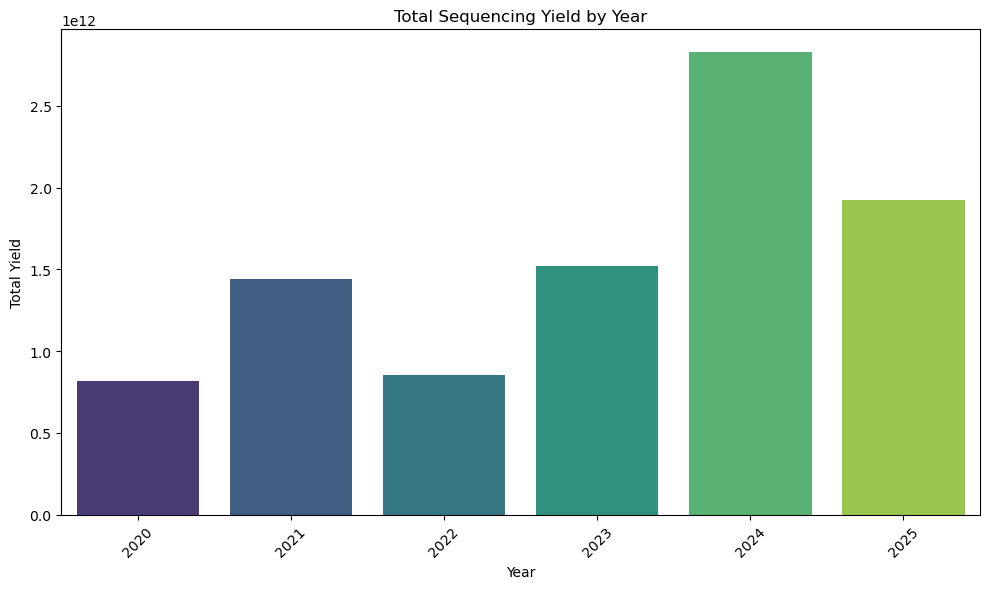

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by year and sum total yield
yearly_yield = master_df_unique.groupby("Year")["Total_yield"].sum().reset_index()

# Sort years for visual order
yearly_yield = yearly_yield.sort_values("Year")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=yearly_yield, x="Year", y="Total_yield", palette="viridis")

plt.title("Total Sequencing Yield by Year")
plt.xlabel("Year")
plt.ylabel("Total Yield")
plt.xticks(rotation=45)
plt.tight_layout()

# Save to PDF
plt.savefig("yield_by_year.pdf")

# Optional: show the plot
plt.show()
